# This version calculates occurrance rate from extracted MRs from training data(performed environment wise)

In [1]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:75% !important; }</style>"))

import csv
from datetime import datetime
from datetime import timedelta
#from struct import pack
import os
import gc
from numpy import abs, max 
import scipy
#from scipy import io
import numpy as np
from matplotlib import pyplot as plt
#from scipy.signal import butter, lfilter
from scipy import signal
#from scipy.signal import blackman
#from scipy.signal import periodogram
#import gc
#import os
import sys
import pandas as pd
#from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.spatial import distance
from scipy import spatial
from cdtw import pydtw 

gc.enable()

video_start = '20190501'#'20190327'#'20181220' #YYYYMMDD
video_end = '20190501'#'20190327'#'20181220' #YYYYMMDD
data_path = '/data/'
sensor_list = ["acc_w","wifi"]#["gyro","acc2","acc_w","wifi","magnetic"]

temp_video_start = video_start[0:4] + "/" + video_start[4:6] + "/" +video_start[6:8]
temp_video_end = video_end[0:4] + "/" + video_end[4:6] + "/" +video_end[6:8]
print temp_video_start
print temp_video_end

video_startdatte = datetime.strptime(temp_video_start,'%Y/%m/%d')
video_enddate = datetime.strptime(temp_video_end,'%Y/%m/%d')

2019/05/01
2019/05/01


# Calculate the distance between each motif representative and the acceleration data

In [2]:
def distance_calc(motif_representatives,acc):
    discovered_motifs = []
    window_size = len(motif_representatives.values[0])
    disc_mot_list = [] 
    dist = []

    for rep in tqdm(motif_representatives.values):
        
        dist_row = []
        for z in range(0,len(acc)):
            candid = acc[z-window_size/2:z+window_size/2].values.reshape(-1)

            if z<window_size/2:
                candid = acc[0:z+window_size/2].values.reshape(-1)

            if z>len(acc)-window_size/2:
                candid = acc[z-window_size/2:len(acc)].values.reshape(-1)

            x = rep.tolist()
            y = candid
            #print len(candid)
            #euclidean_norm = lambda x, y: np.abs(x - y)
            #d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=euclidean_norm)
            #d = dtw.distance_fast(s1, s2)
            d = pydtw.dtw(x,y).get_dist()
            dist_row.extend([d])
        
        dist.append(dist_row)
    return dist

In [3]:
def normalize_distance(dist):
    norm_dist = []
    for rows in dist:
        norm_dist.append(rows/np.array(rows).max())
        
    return norm_dist

In [4]:
def binarize_dist(norm_dist):
    disc_mot = []
    for rows in norm_dist:
        disc_mot_row = []
        for elements in rows:
            if elements < 0.15:
                disc_mot_row.extend([1])
            else:
                disc_mot_row.extend([0])
        disc_mot.append(disc_mot_row)
        
    return disc_mot

In [5]:
def make_place_cluster(location_list):
    place_cluster = location_list

    place_cluster = place_cluster.values.reshape(-1).tolist()
    places = set(place_cluster)

    place = []
    for p in places:
        loc = []
        for c in place_cluster:
            if p == c:
                loc.append(1)
            else:
                loc.append(0)
        place.append(loc)
        
    return place

In [6]:
def feature_calc(place, disc_mot, en):
    #Concat features
    feat = []
    mot_sum = 0
    for location in range(0,len(place)):
        for row in range(0,len(disc_mot)):
            count = 0
            for element in range(0,len(place[location])):
                if place[location][element] == 1:
                    if disc_mot[row][element] == 1:
                        count = count+1
            feat.append([location,row,count])
            
    feature_list = []
    for f in feat:

        feature_list.append([f[0],f[1],float(f[2])])
    #feature_list.append(ft)

    feature_list = pd.DataFrame(feature_list)
    
    env_wise_sum = []
    
    #### This is for dividing the environment-wise occurrences by environment-wise number of all occurrences
    #for locs in set(feature_list[0]):
    #    env_wise_sum.append([locs,feature_list[feature_list[0]==locs][2].sum()])

    
    ### This is for dividing the environment-wise occurrences by the length of the environment
    unique,counts = np.unique(location_list.values,return_counts=True)
    env_wise_sum = np.stack([unique,counts], axis = 1)

    print env_wise_sum


    env_wise_sum

    test = []
    for sums in env_wise_sum:
        #print sums
        test.append(list(feature_list[feature_list[0]==sums[0]][2]/sums[1]))

    feature_list['3'] = np.array(test).reshape(-1)

    feature_list.drop(feature_list.columns[2], axis=1, inplace=True)
    
    #Location wise features (separation)
    loc_wise_ft = []
    for e in set(feature_list.values[:,0]):
        lwf = []
        for row in feature_list.values:
            if row[0] == e:
                #print row[2]
                lwf.extend([float(row[2])])
        lwf.extend([e])
        loc_wise_ft.append(lwf)
    
    #Visualize features

    #count = 0
    #for rw in features.values:
        #plt.figure(figsize=(30,5))
        #plt.xlim(0,len(rw[:-1]))
        #plt.plot(rw[:-1])

        #plt.savefig(train_root+ "pics/" + "en:" + str(en) + "-" + "loc:" +str(count) +".png")
        #plt.show()
     #   count = count + 1
        
    return loc_wise_ft

In [7]:
root = "env/"

In [8]:
envs = os.listdir(root)
envs = envs[0:len(envs)-1]
print envs
envs = [int(x) for x in envs]
envs.sort()

print "Please select a testing environment from the following environments list:"

for i in envs:
    print "Environment: (",i,")"
    
test_env = raw_input("Testing environment ")

test_env = int(test_env)

['5', '10', '8', '9', '6']
Please select a testing environment from the following environments list:
Environment: ( 5 )
Environment: ( 6 )
Environment: ( 8 )
Environment: ( 9 )
Environment: ( 10 )
Testing environment 5


In [9]:
envs.remove(test_env)
train_env=envs

In [10]:
train_env

[6, 8, 9, 10]

In [11]:
train_root = root + str(test_env) + "/dat/" + "train_dat/"
test_root = root + str(test_env) + "/dat/" + "test_dat/" 

In [12]:
motif_representatives = pd.read_csv("env/" + str(test_env) + "/dat/train_dat/" + "motif_representatives", header=None)

#Pre-processing
motif_representatives.index = motif_representatives[0]

ids = motif_representatives.index
ids = ids.astype(int)
motif_representatives.drop([0], axis=1,inplace=True)

# Reading label list of all trainig environments and concatenating
loc_list = pd.DataFrame()
for e in train_env:
    df_a = pd.read_csv("env/" + str(e) + "/dat/" + "labels", header=None)

    loc_list = pd.concat([loc_list,df_a],axis = 0,sort=False,ignore_index = True)



  0%|          | 0/77 [00:00<?, ?it/s]

*** Extracting features from environment [ 6 ] ***




  1%|▏         | 1/77 [00:01<02:04,  1.64s/it]

  3%|▎         | 2/77 [00:03<02:03,  1.65s/it]

  4%|▍         | 3/77 [00:05<02:03,  1.66s/it]

  5%|▌         | 4/77 [00:06<01:59,  1.63s/it]

  6%|▋         | 5/77 [00:08<01:56,  1.61s/it]

  8%|▊         | 6/77 [00:09<01:52,  1.59s/it]

  9%|▉         | 7/77 [00:11<01:50,  1.57s/it]

 10%|█         | 8/77 [00:12<01:49,  1.59s/it]

 12%|█▏        | 9/77 [00:14<01:48,  1.60s/it]

 13%|█▎        | 10/77 [00:16<01:46,  1.59s/it]

 14%|█▍        | 11/77 [00:17<01:44,  1.58s/it]

 16%|█▌        | 12/77 [00:19<01:42,  1.57s/it]

 17%|█▋        | 13/77 [00:20<01:42,  1.60s/it]

 18%|█▊        | 14/77 [00:22<01:41,  1.60s/it]

 19%|█▉        | 15/77 [00:24<01:40,  1.61s/it]

 21%|██        | 16/77 [00:25<01:38,  1.62s/it]

 22%|██▏       | 17/77 [00:27<01:39,  1.65s/it]

 23%|██▎       | 18/77 [00:29<01:36,  1.64s/it]

 25%|██▍       | 19/77 [00:30<01:34,  1.63s/it]

 26%|██▌       | 20/77 [00:32<01:32,  1.62s/it]

 27%|██▋       | 21/77 [00:

[[   0  933]
 [   1 1259]
 [   2 1044]
 [   3  918]
 [   4  846]]
*** Extracting features from environment [ 8 ] ***




  1%|▏         | 1/77 [00:01<02:02,  1.61s/it]

  3%|▎         | 2/77 [00:03<02:01,  1.62s/it]

  4%|▍         | 3/77 [00:04<01:59,  1.62s/it]

  5%|▌         | 4/77 [00:06<01:58,  1.62s/it]

  6%|▋         | 5/77 [00:08<01:59,  1.66s/it]

  8%|▊         | 6/77 [00:09<01:56,  1.63s/it]

  9%|▉         | 7/77 [00:11<01:54,  1.64s/it]

 10%|█         | 8/77 [00:13<01:53,  1.64s/it]

 12%|█▏        | 9/77 [00:14<01:49,  1.62s/it]

 13%|█▎        | 10/77 [00:16<01:47,  1.61s/it]

 14%|█▍        | 11/77 [00:17<01:46,  1.61s/it]

 16%|█▌        | 12/77 [00:19<01:45,  1.62s/it]

 17%|█▋        | 13/77 [00:21<01:43,  1.62s/it]

 18%|█▊        | 14/77 [00:22<01:41,  1.61s/it]

 19%|█▉        | 15/77 [00:24<01:40,  1.62s/it]

 21%|██        | 16/77 [00:25<01:38,  1.61s/it]

 22%|██▏       | 17/77 [00:27<01:36,  1.61s/it]

 23%|██▎       | 18/77 [00:29<01:35,  1.62s/it]

 25%|██▍       | 19/77 [00:30<01:36,  1.66s/it]

 26%|██▌       | 20/77 [00:32<01:33,  1.64s/it]

 27%|██▋       | 21/77 [00:

[[   0 1121]
 [   1 1320]
 [   2  655]
 [   3  869]
 [   4 1036]]




  0%|          | 0/77 [00:00<?, ?it/s]

*** Extracting features from environment [ 9 ] ***




  1%|▏         | 1/77 [00:01<02:02,  1.61s/it]

  3%|▎         | 2/77 [00:03<02:00,  1.60s/it]

  4%|▍         | 3/77 [00:04<01:59,  1.62s/it]

  5%|▌         | 4/77 [00:06<01:57,  1.61s/it]

  6%|▋         | 5/77 [00:08<01:55,  1.60s/it]

  8%|▊         | 6/77 [00:09<01:54,  1.62s/it]

  9%|▉         | 7/77 [00:11<01:52,  1.61s/it]

 10%|█         | 8/77 [00:12<01:51,  1.61s/it]

 12%|█▏        | 9/77 [00:14<01:49,  1.61s/it]

 13%|█▎        | 10/77 [00:16<01:48,  1.62s/it]

 14%|█▍        | 11/77 [00:17<01:48,  1.64s/it]

 16%|█▌        | 12/77 [00:19<01:46,  1.64s/it]

 17%|█▋        | 13/77 [00:21<01:45,  1.64s/it]

 18%|█▊        | 14/77 [00:22<01:42,  1.63s/it]

 19%|█▉        | 15/77 [00:24<01:42,  1.65s/it]

 21%|██        | 16/77 [00:26<01:41,  1.66s/it]

 22%|██▏       | 17/77 [00:27<01:40,  1.67s/it]

 23%|██▎       | 18/77 [00:29<01:38,  1.67s/it]

 25%|██▍       | 19/77 [00:31<01:37,  1.68s/it]

 26%|██▌       | 20/77 [00:32<01:33,  1.64s/it]

 27%|██▋       | 21/77 [00:

[[   0 1293]
 [   1  921]
 [   2  680]
 [   3 1200]
 [   4  907]]




  0%|          | 0/77 [00:00<?, ?it/s]

*** Extracting features from environment [ 10 ] ***




  1%|▏         | 1/77 [00:01<01:59,  1.57s/it]

  3%|▎         | 2/77 [00:03<01:59,  1.59s/it]

  4%|▍         | 3/77 [00:04<01:57,  1.59s/it]

  5%|▌         | 4/77 [00:06<01:56,  1.59s/it]

  6%|▋         | 5/77 [00:07<01:53,  1.58s/it]

  8%|▊         | 6/77 [00:09<01:53,  1.59s/it]

  9%|▉         | 7/77 [00:11<01:51,  1.60s/it]

 10%|█         | 8/77 [00:12<01:49,  1.58s/it]

 12%|█▏        | 9/77 [00:14<01:46,  1.57s/it]

 13%|█▎        | 10/77 [00:15<01:45,  1.57s/it]

 14%|█▍        | 11/77 [00:17<01:44,  1.58s/it]

 16%|█▌        | 12/77 [00:19<01:43,  1.59s/it]

 17%|█▋        | 13/77 [00:20<01:42,  1.61s/it]

 18%|█▊        | 14/77 [00:22<01:41,  1.60s/it]

 19%|█▉        | 15/77 [00:23<01:39,  1.61s/it]

 21%|██        | 16/77 [00:25<01:38,  1.62s/it]

 22%|██▏       | 17/77 [00:27<01:37,  1.63s/it]

 23%|██▎       | 18/77 [00:28<01:36,  1.63s/it]

 25%|██▍       | 19/77 [00:30<01:35,  1.64s/it]

 26%|██▌       | 20/77 [00:32<01:34,  1.66s/it]

 27%|██▋       | 21/77 [00:

[[   0  752]
 [   1  900]
 [   2  853]
 [   3 1117]
 [   4 1379]]


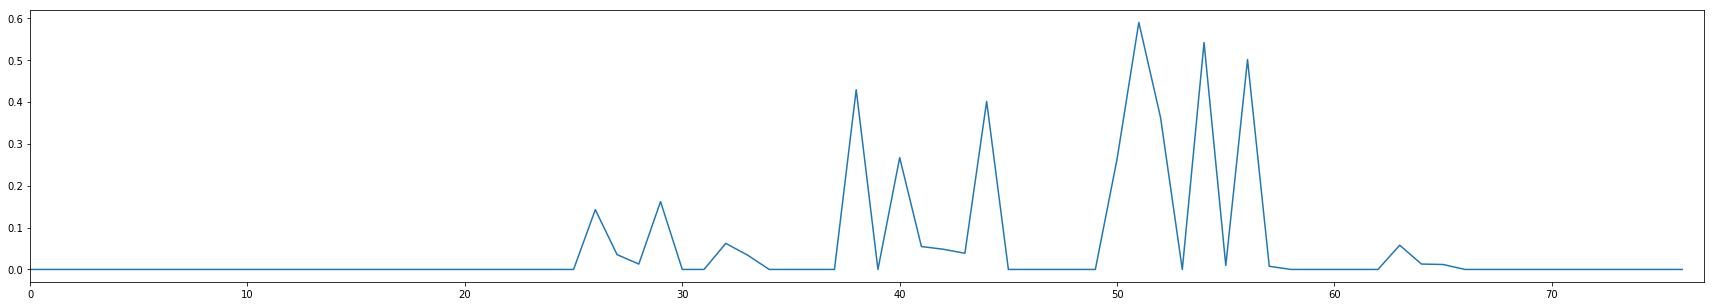

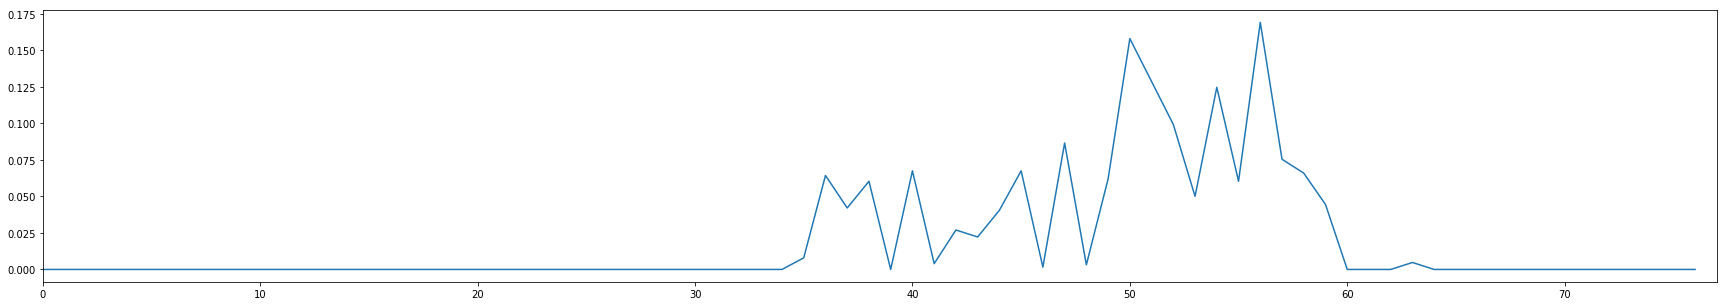

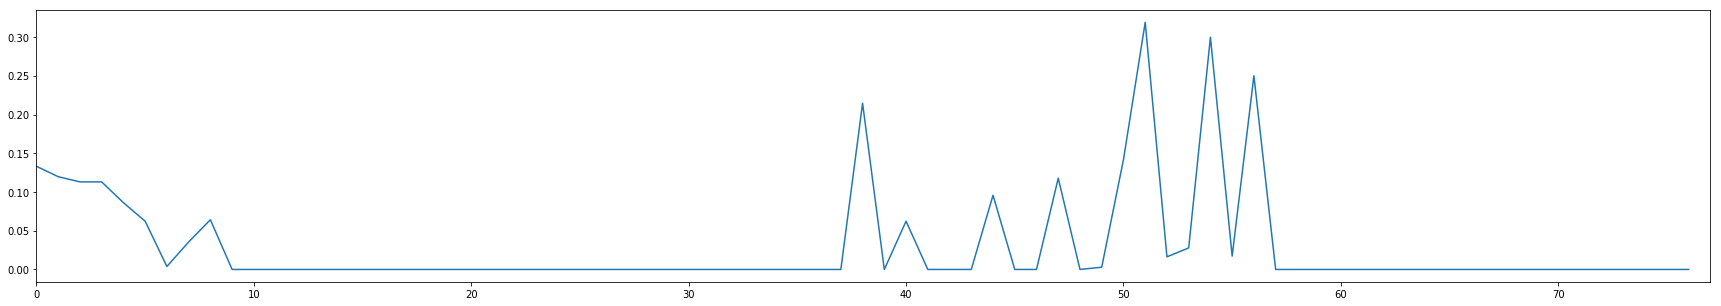

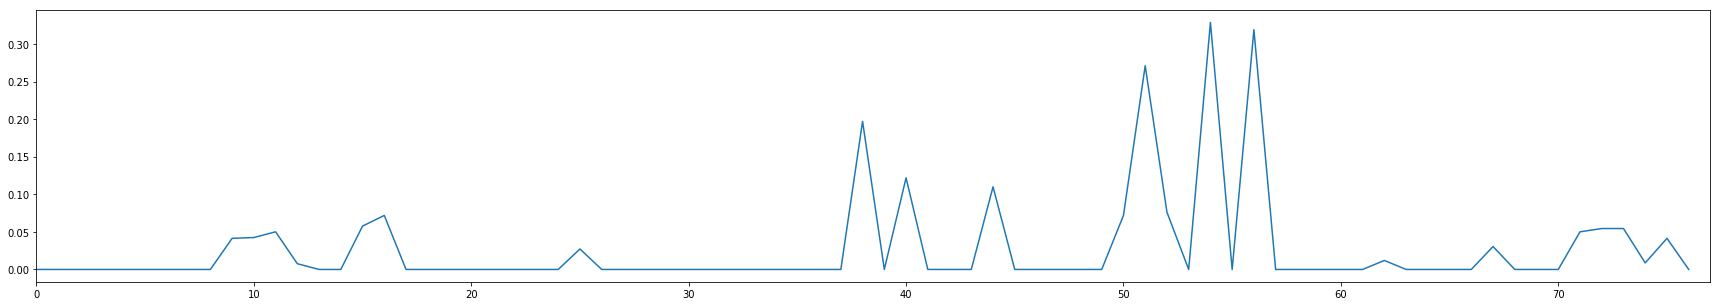

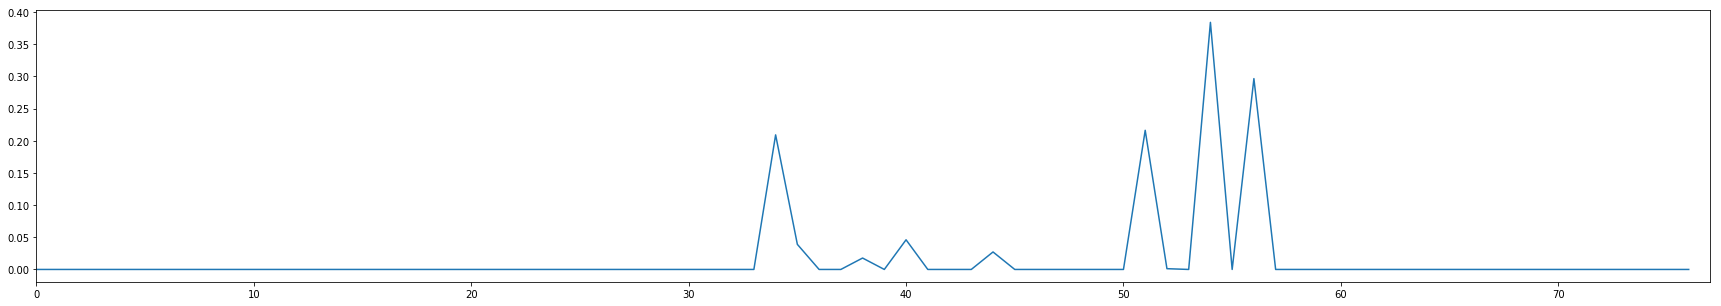

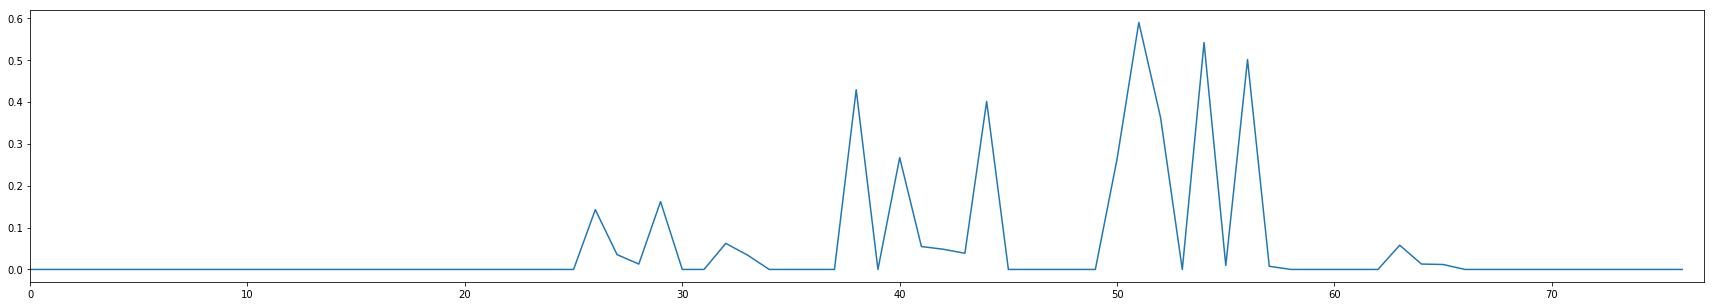

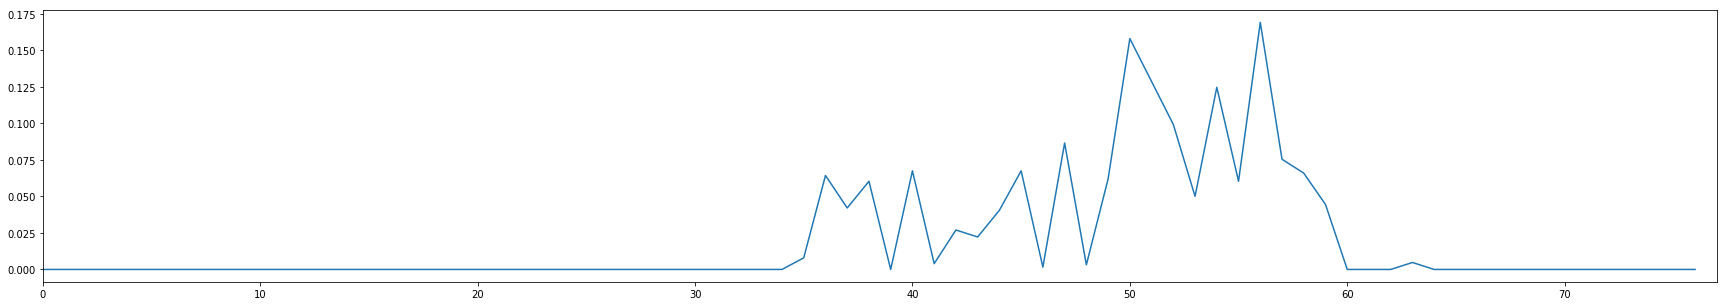

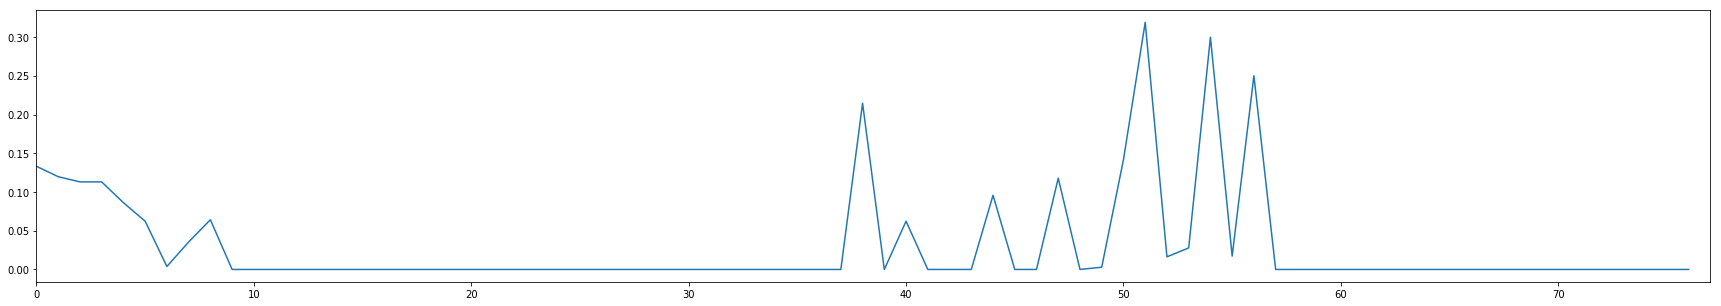

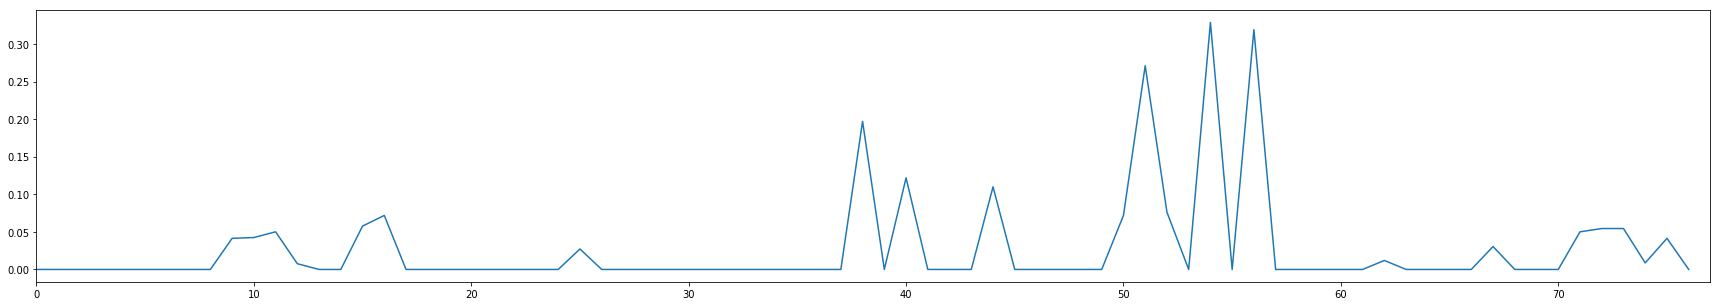

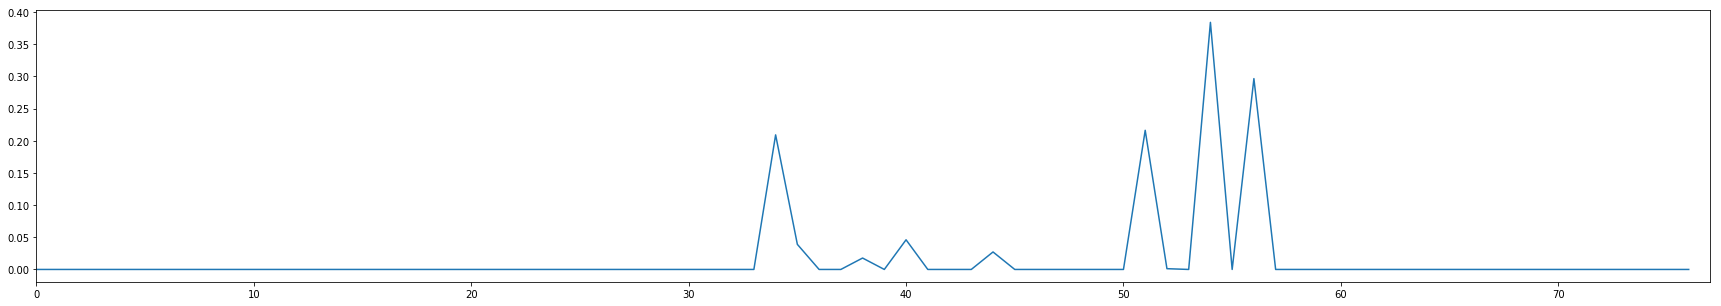

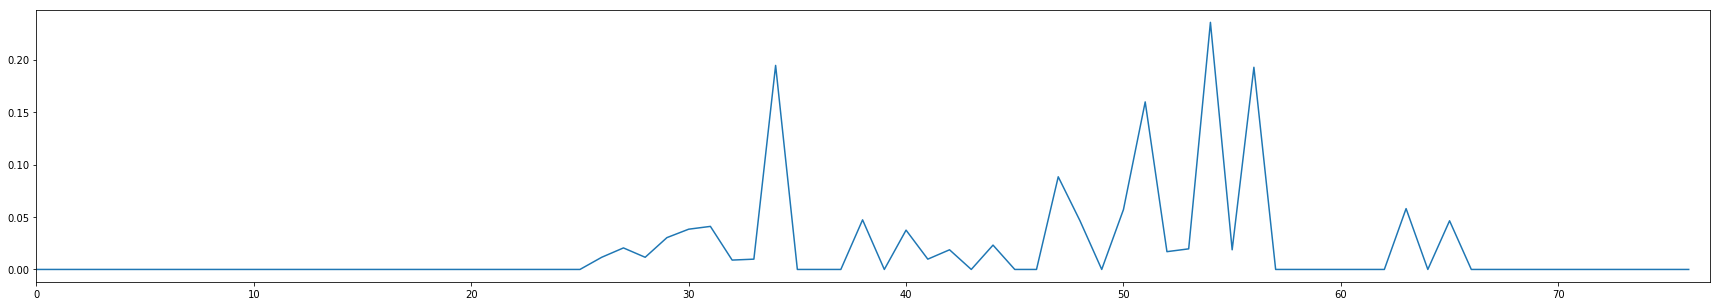

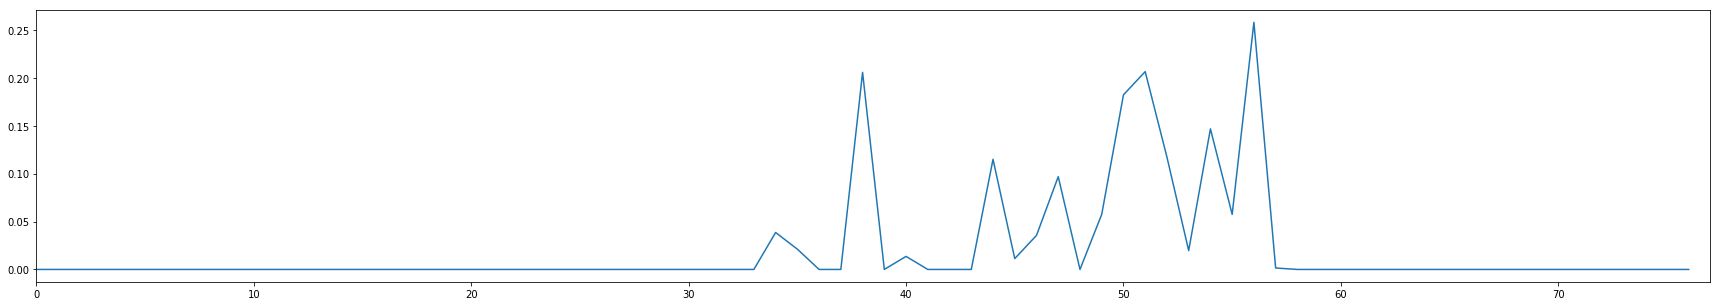

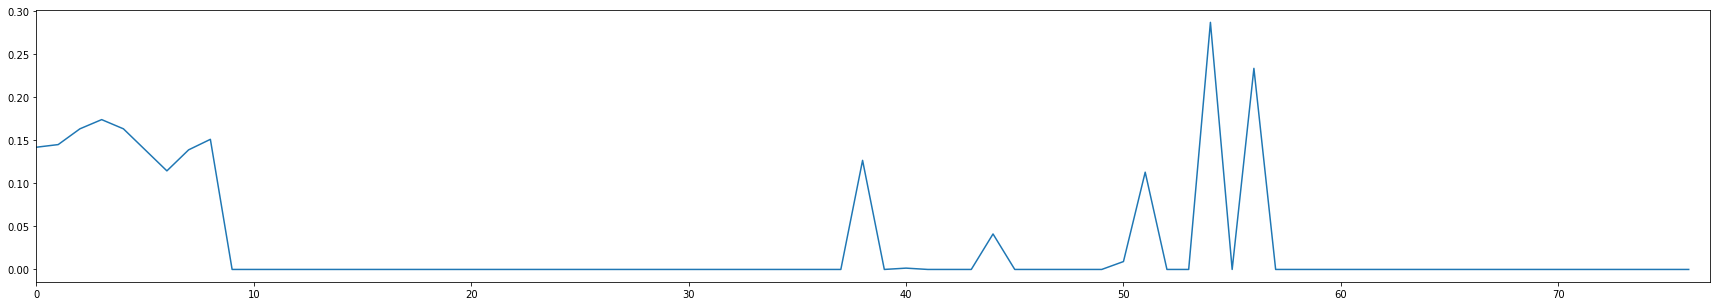

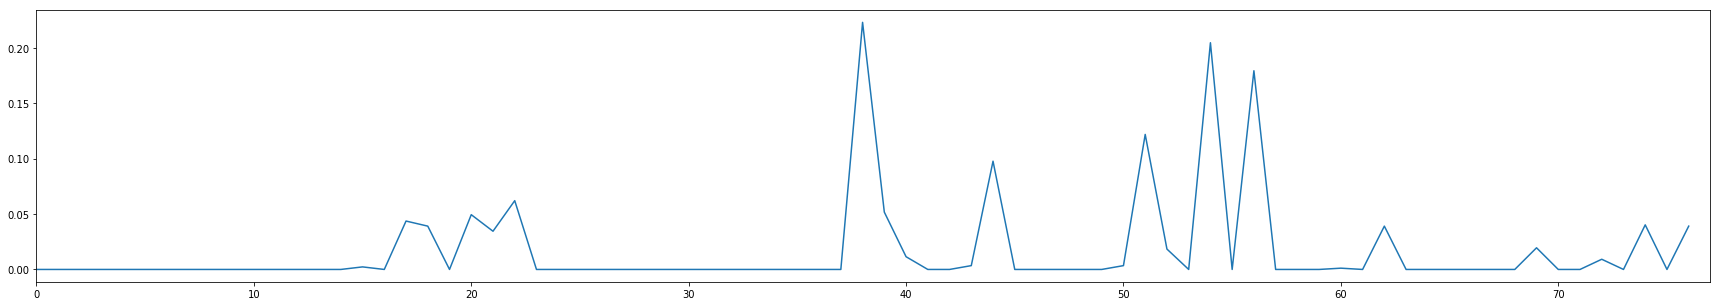

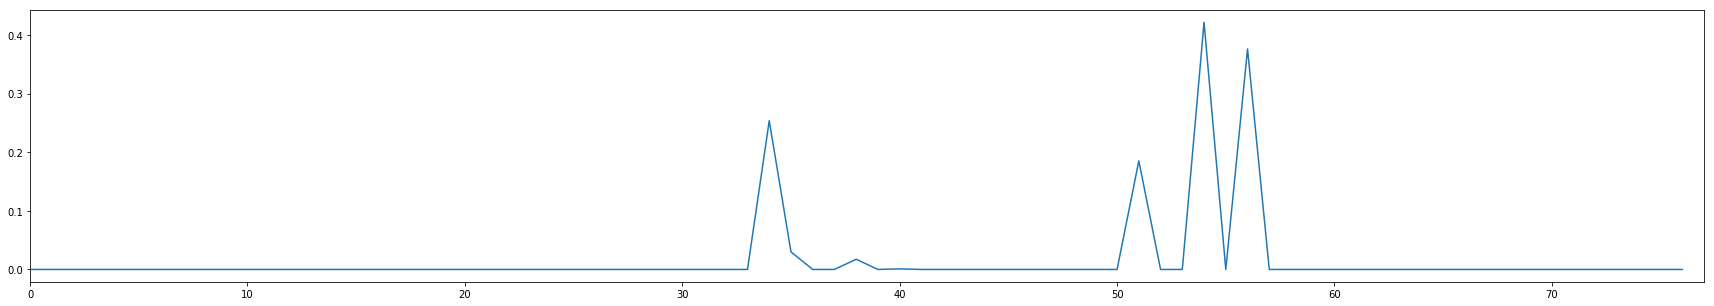

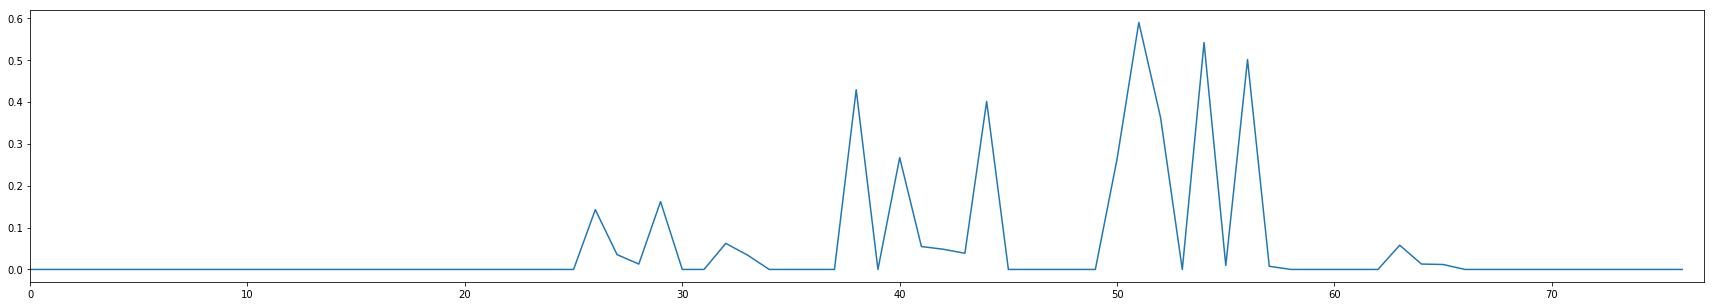

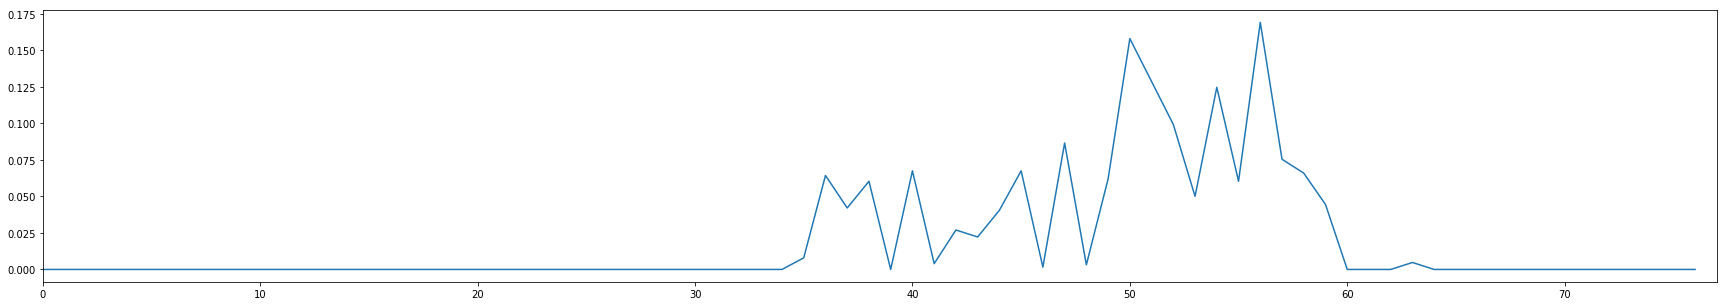

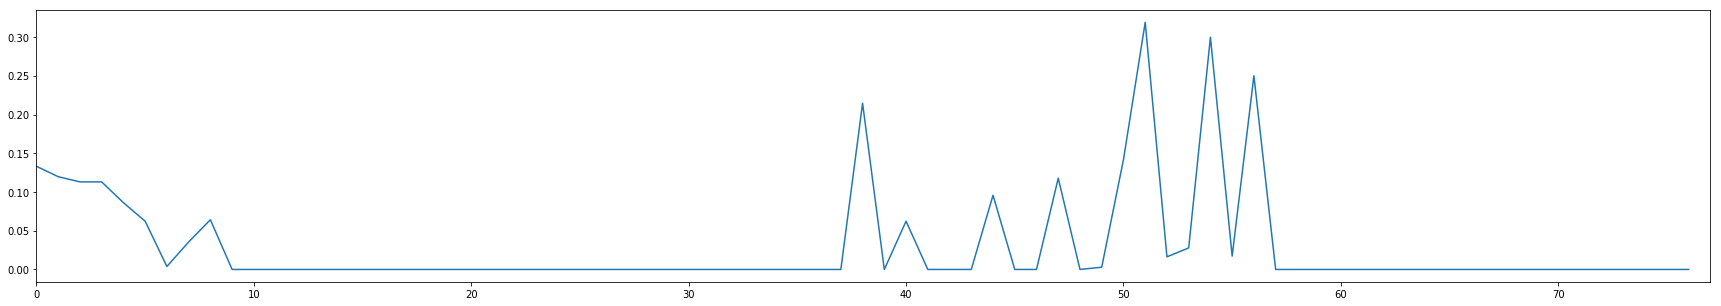

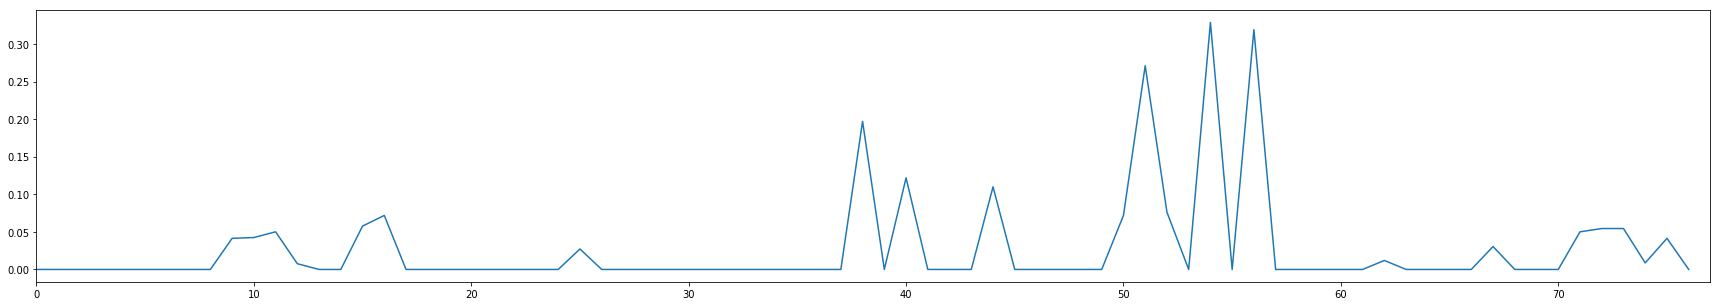

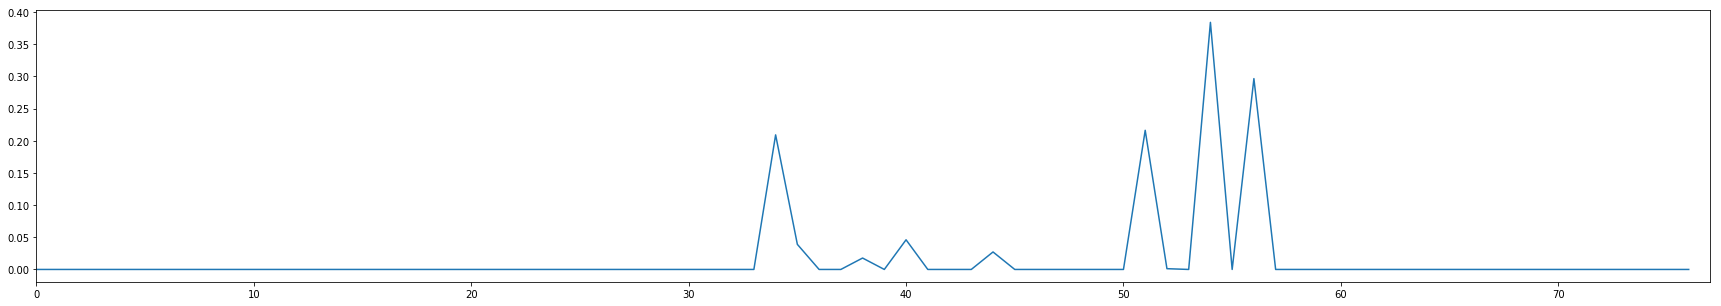

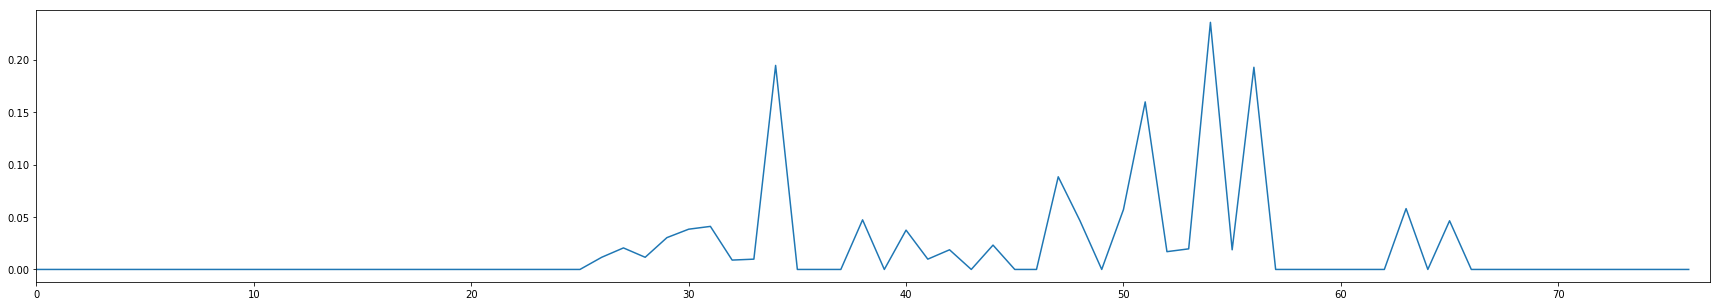

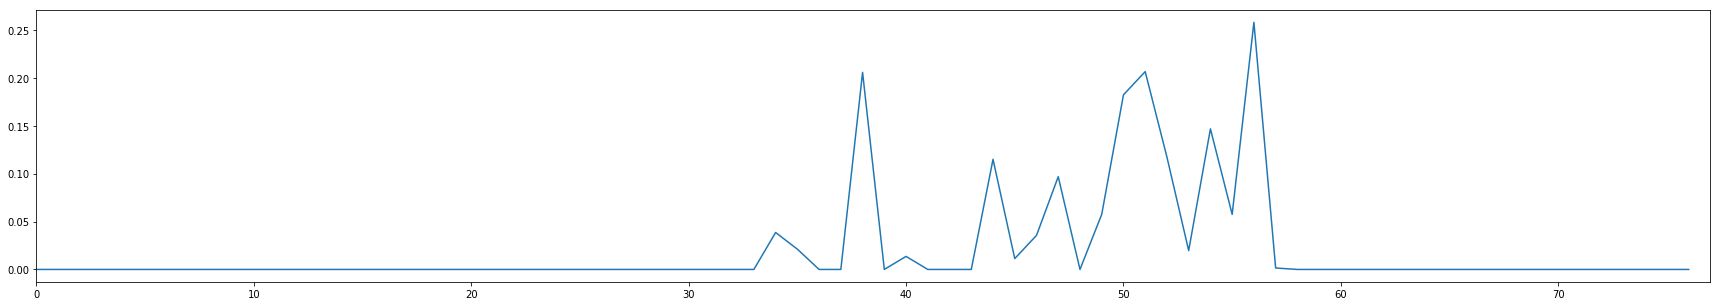

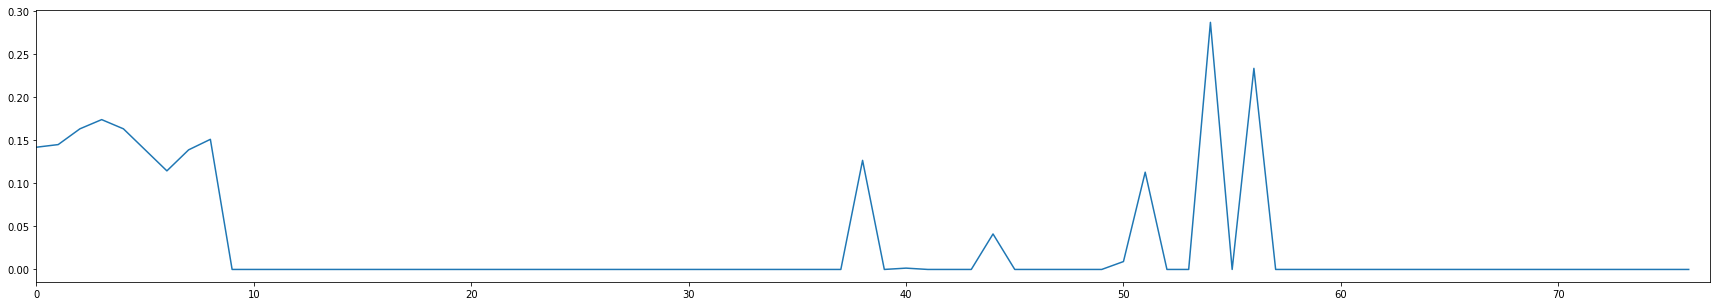

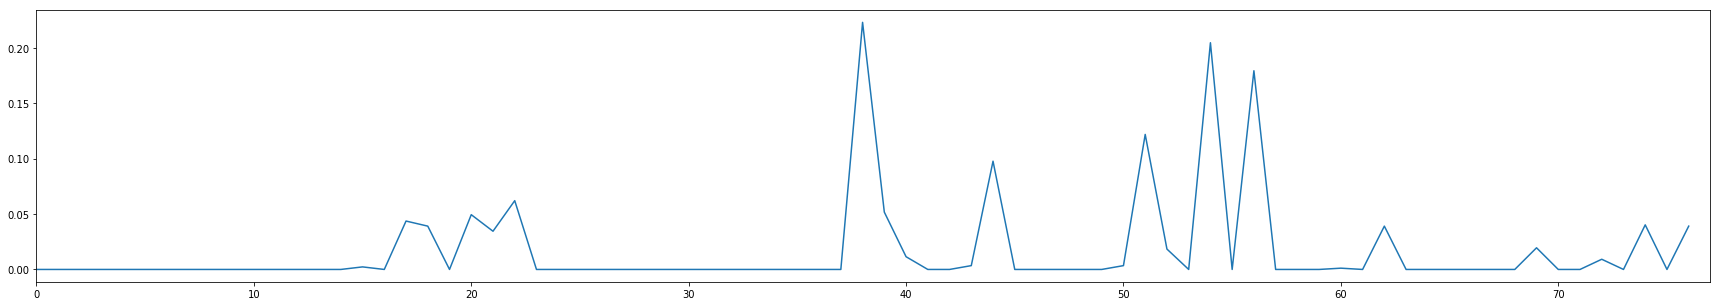

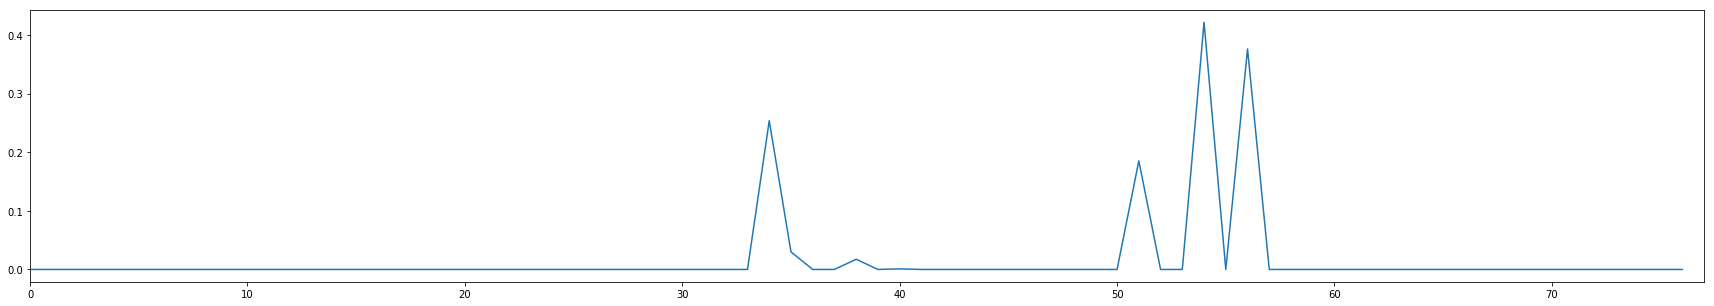

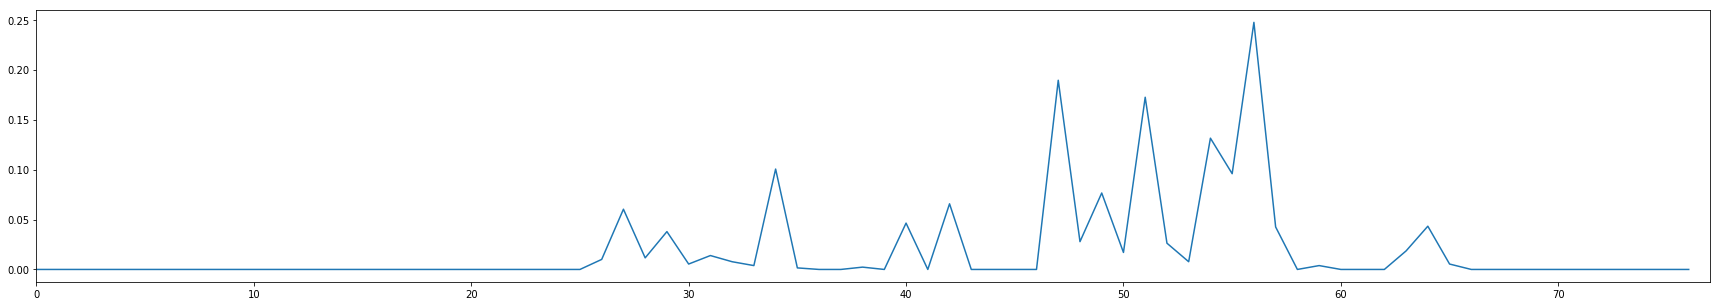

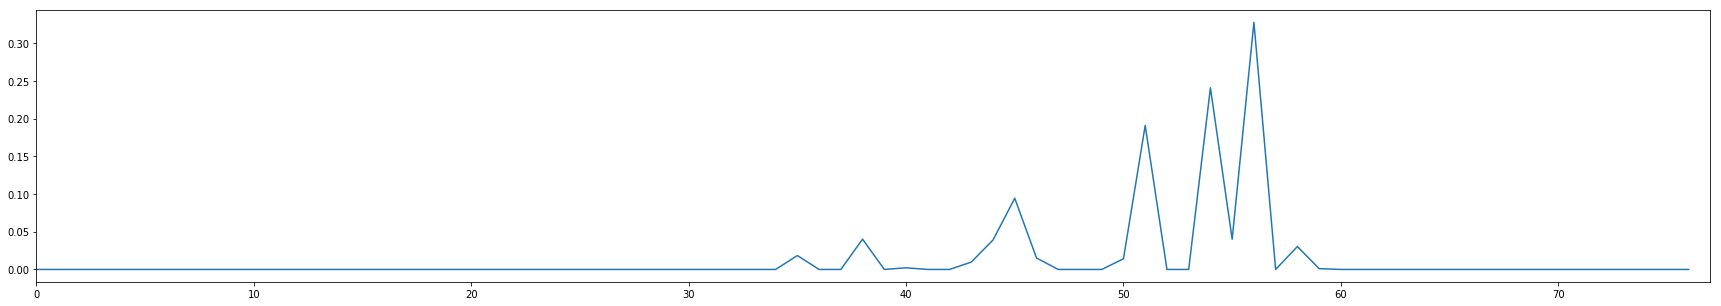

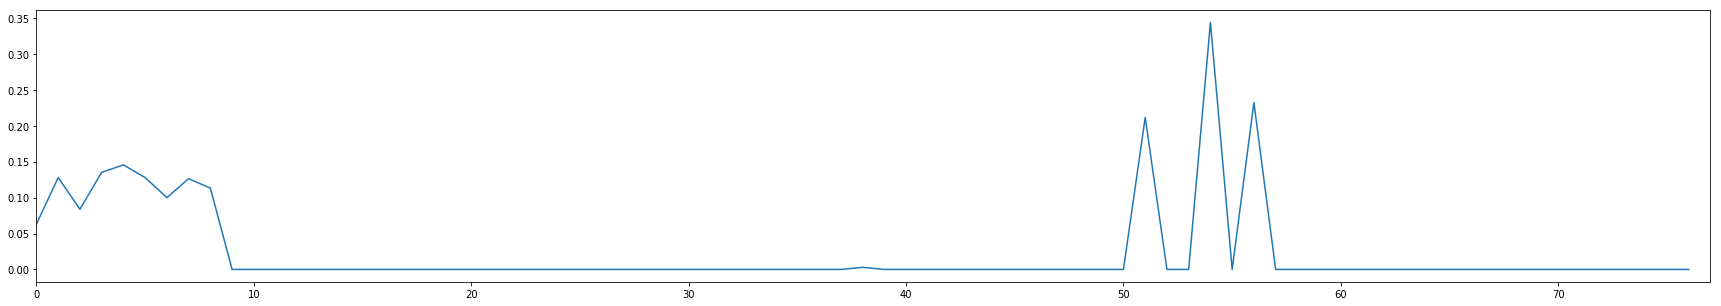

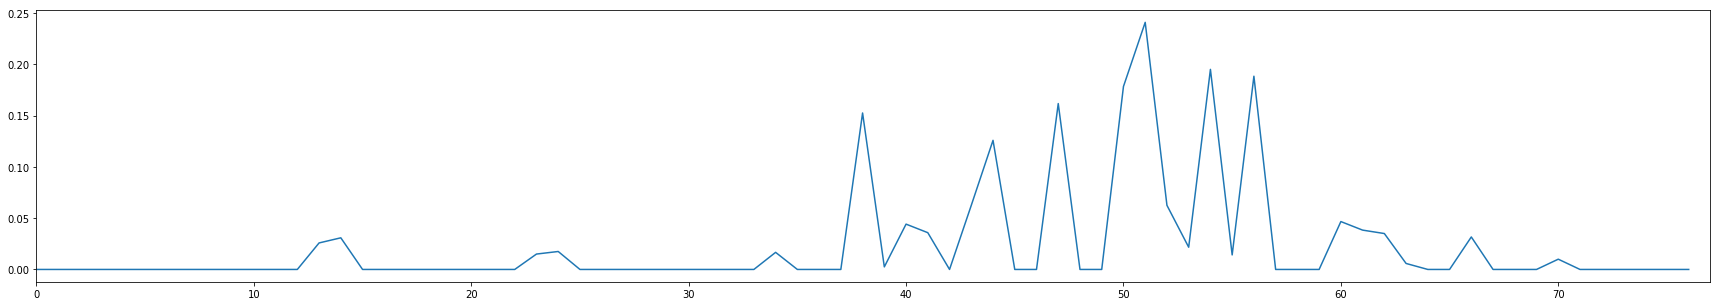

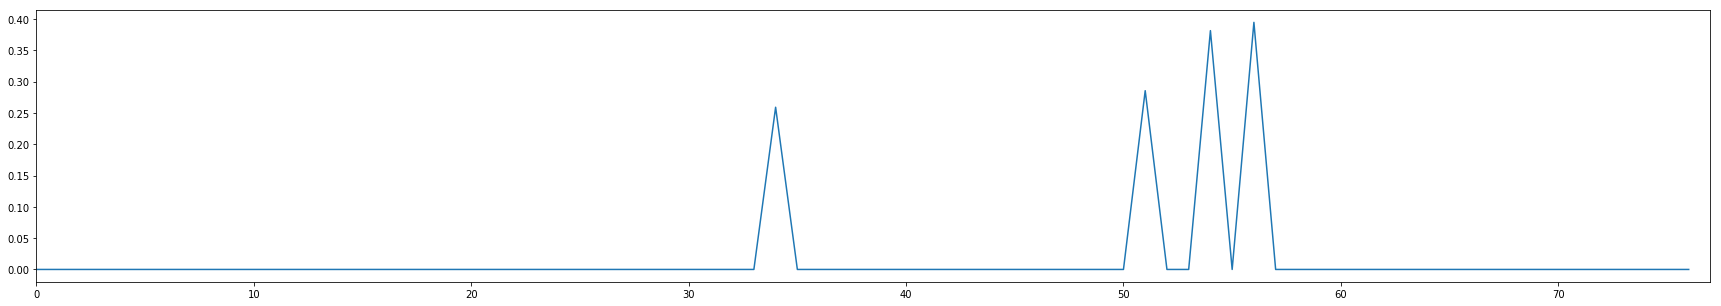

In [65]:
features = pd.DataFrame()
for en in train_env:
    print "*** Extracting features from environment [",en,"] ***"
    acc = pd.read_csv("env/" + str(en) + "/dat/" + "acc")
    location_list = pd.read_csv("env/" + str(en) + "/dat/" + "labels")
    acc.drop(["Unnamed: 0"], axis=1,inplace=True)
    location_list.drop(["Unnamed: 0"], axis=1,inplace=True)  
    
    #Calcuate distance
    dist = distance_calc(motif_representatives,acc)

    norm_dist = normalize_distance(dist)
    
    pd.DataFrame(norm_dist)
    disc_mot = binarize_dist(norm_dist)
    #pd.DataFrame(disc_mot).to_csv(train_root + "features", header=False, index=False)
    
    place = make_place_cluster(location_list)
    loc_wise_ft = feature_calc(place, disc_mot, en)
    
    pd.DataFrame(loc_wise_ft)
    
    features = pd.concat([features,pd.DataFrame(loc_wise_ft)],axis = 0,sort=False,ignore_index = True)
    
features.to_csv(train_root + "features", header=False, index=False) 

In [13]:
features = pd.read_csv(train_root + "features", header=None)

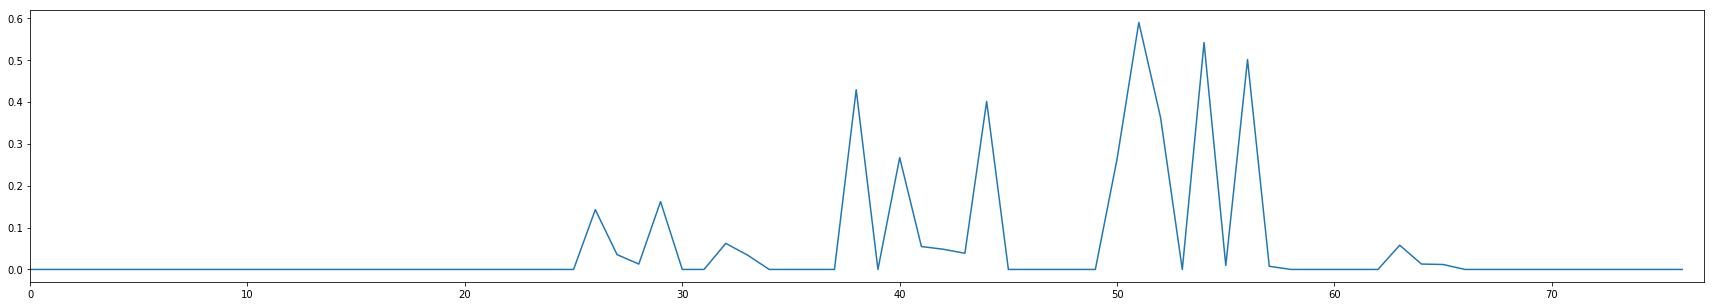

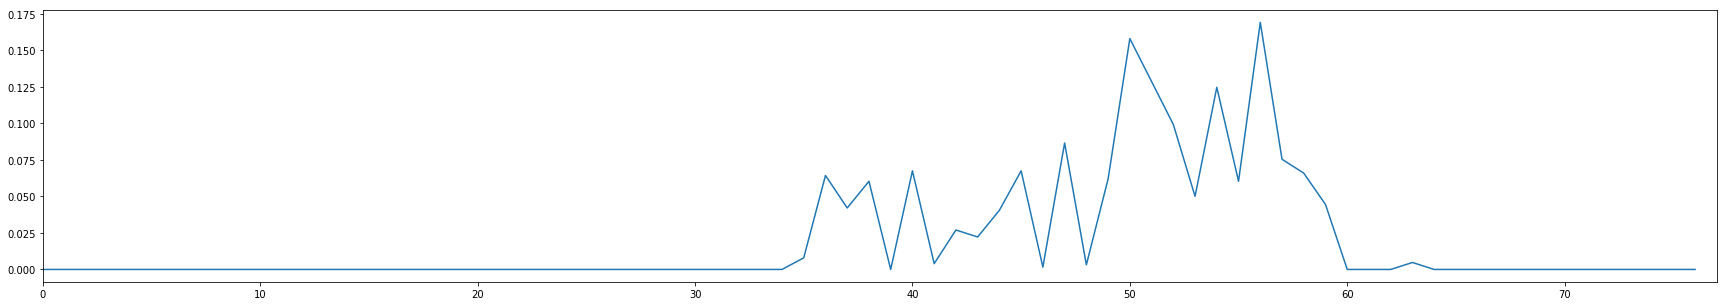

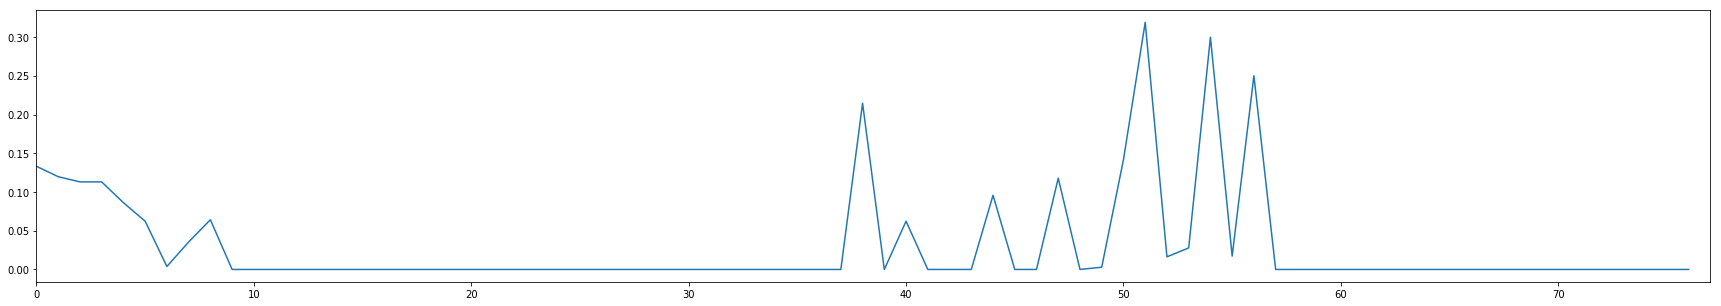

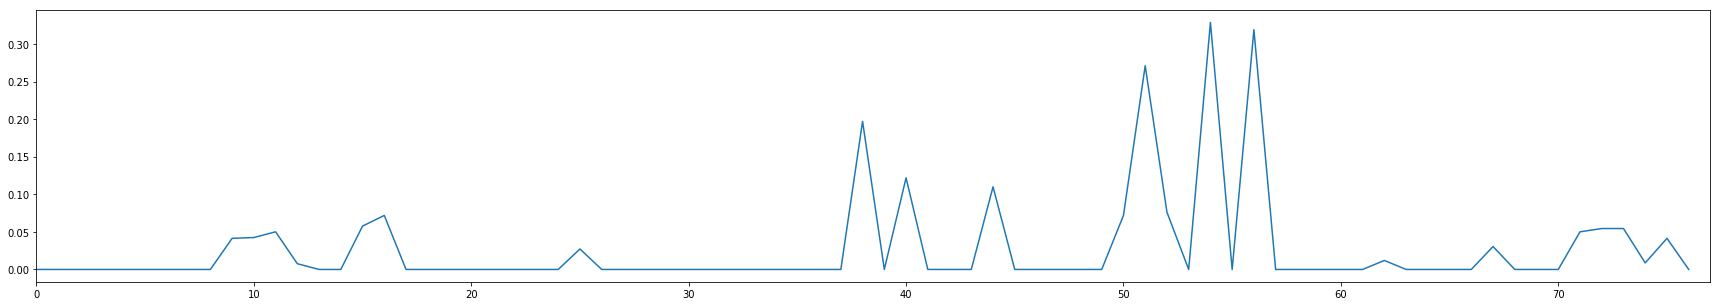

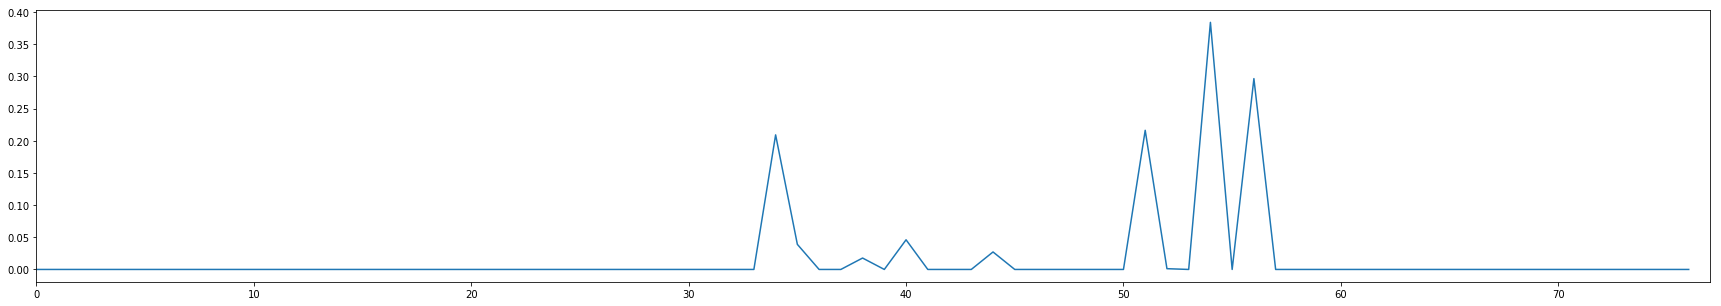

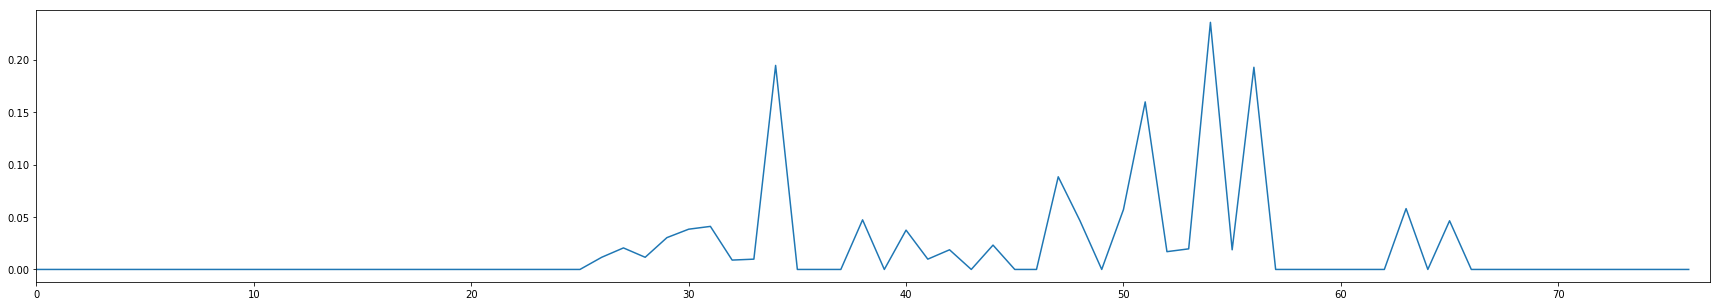

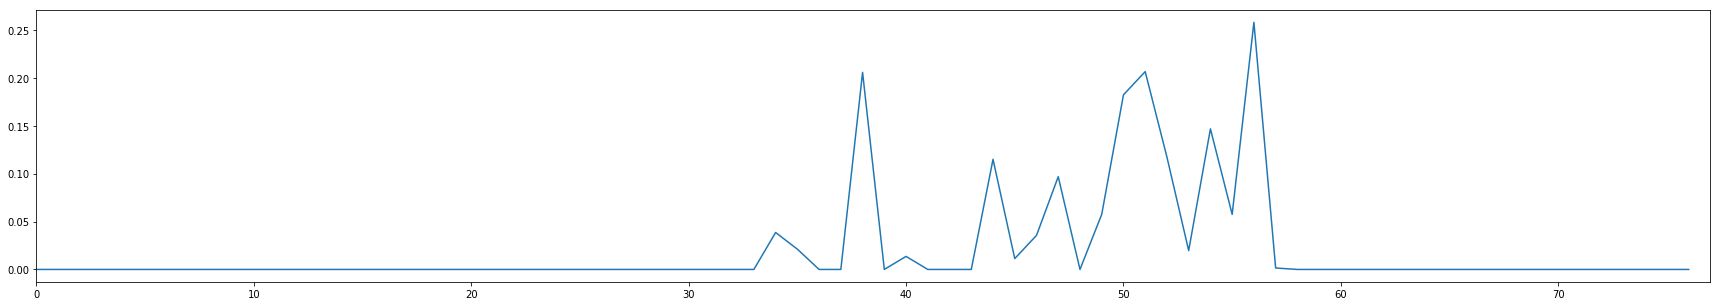

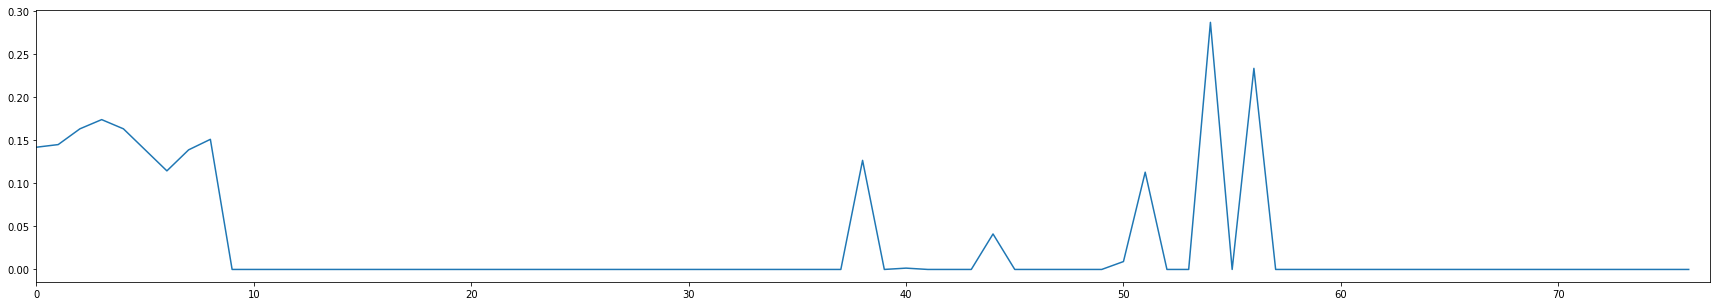

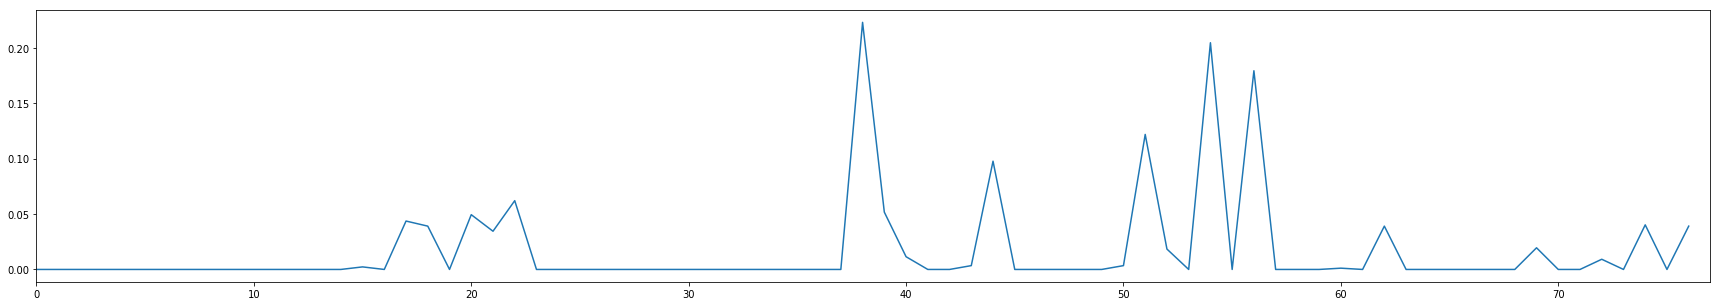

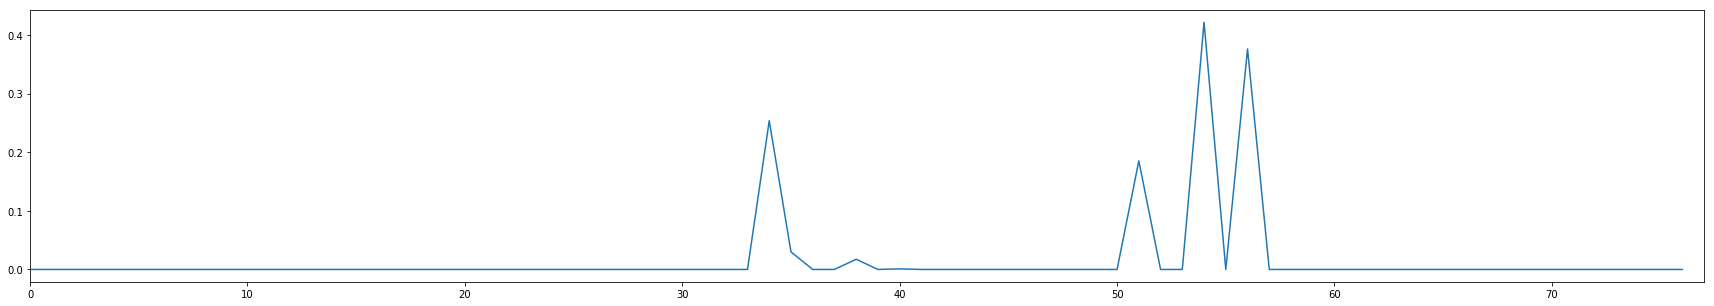

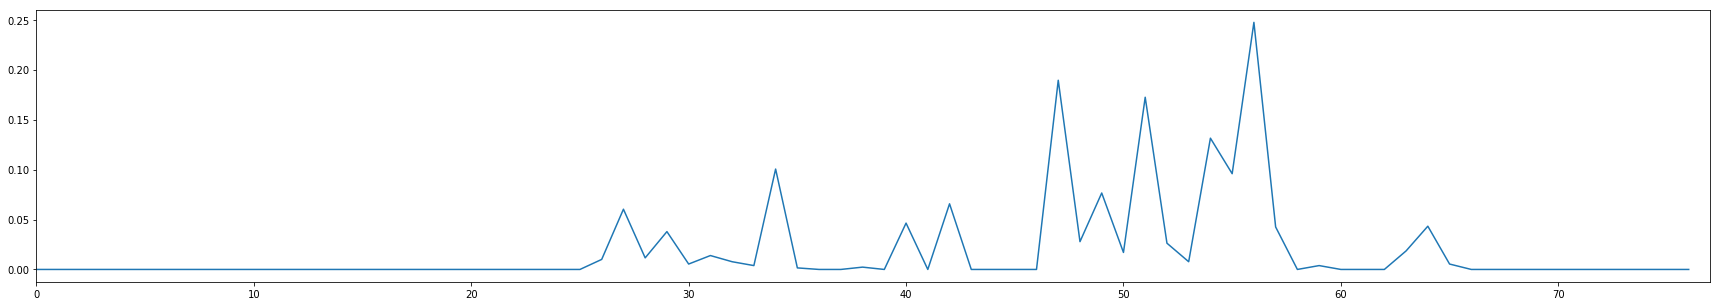

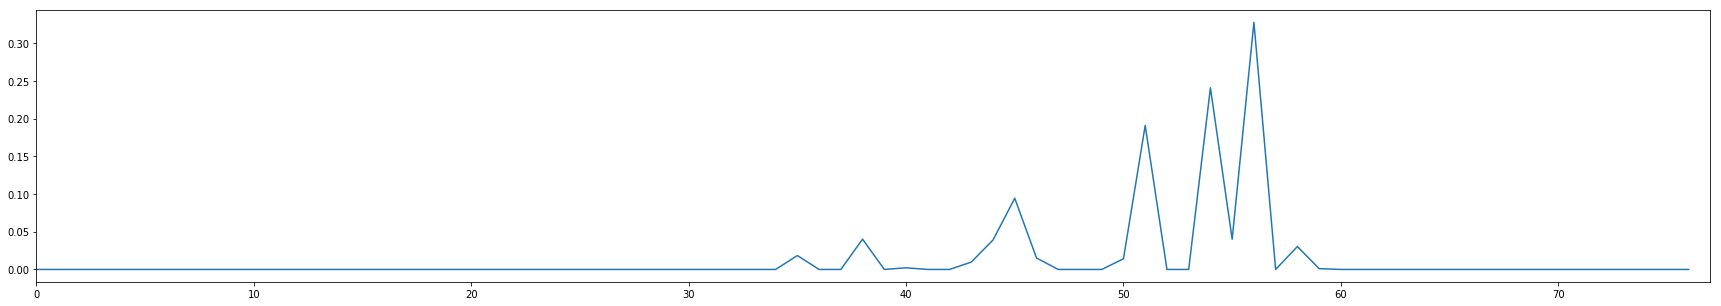

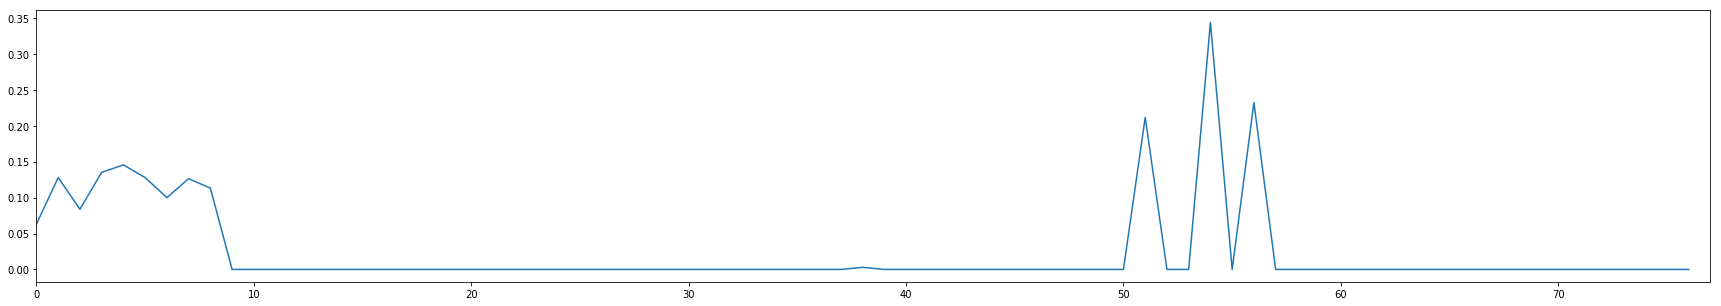

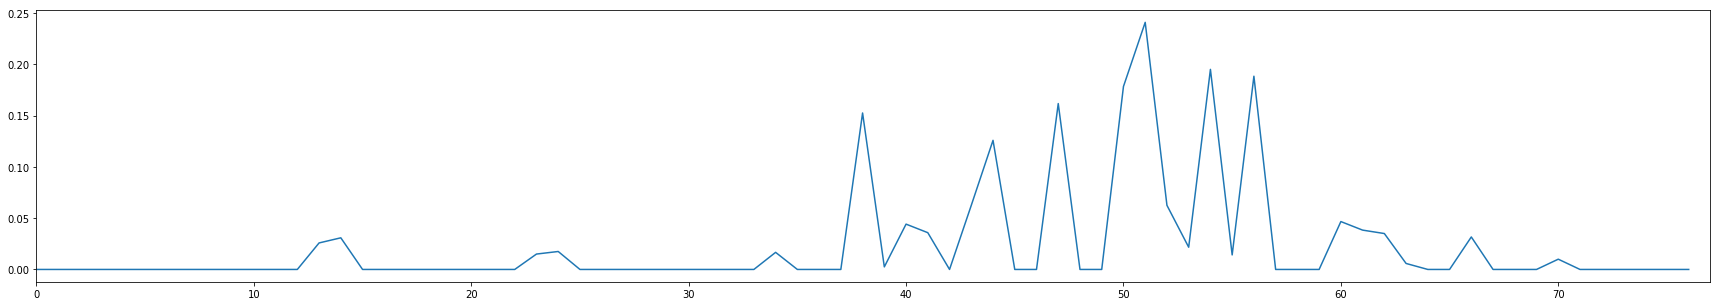

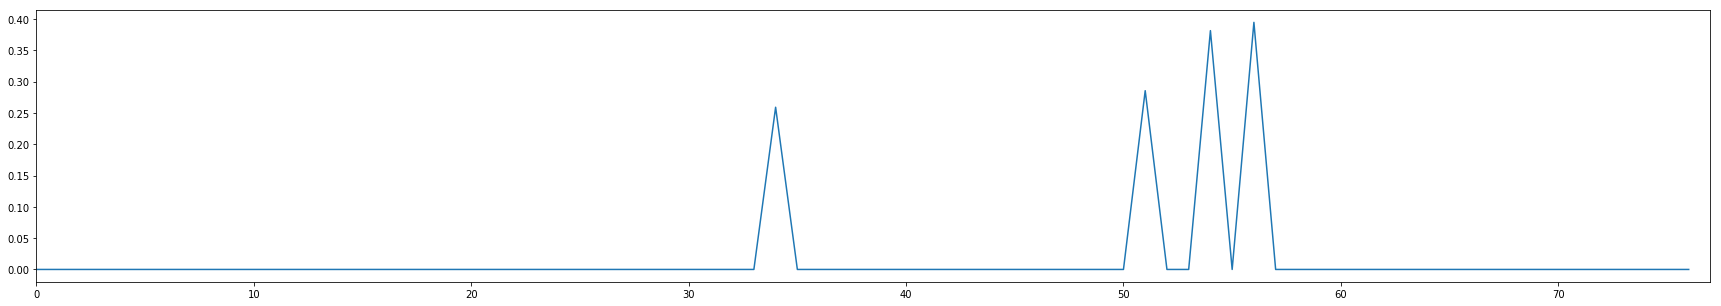

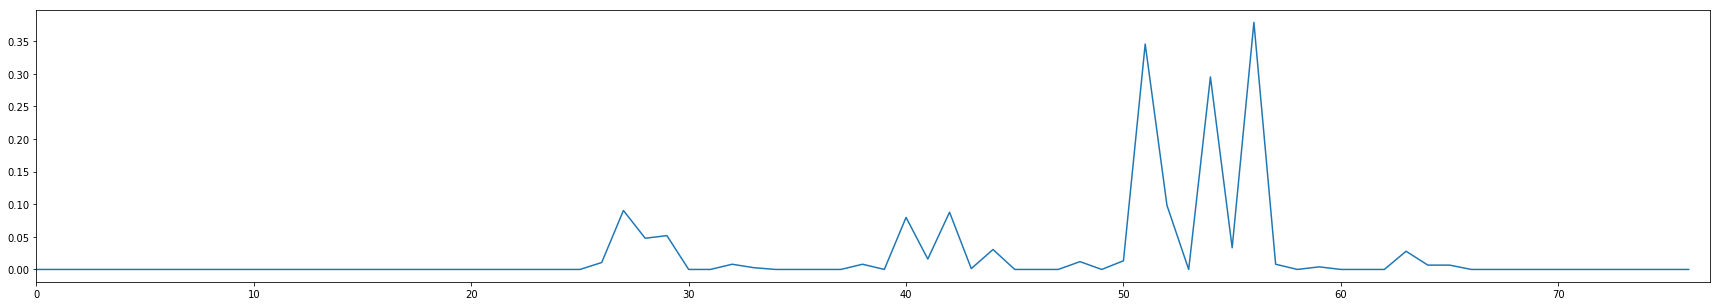

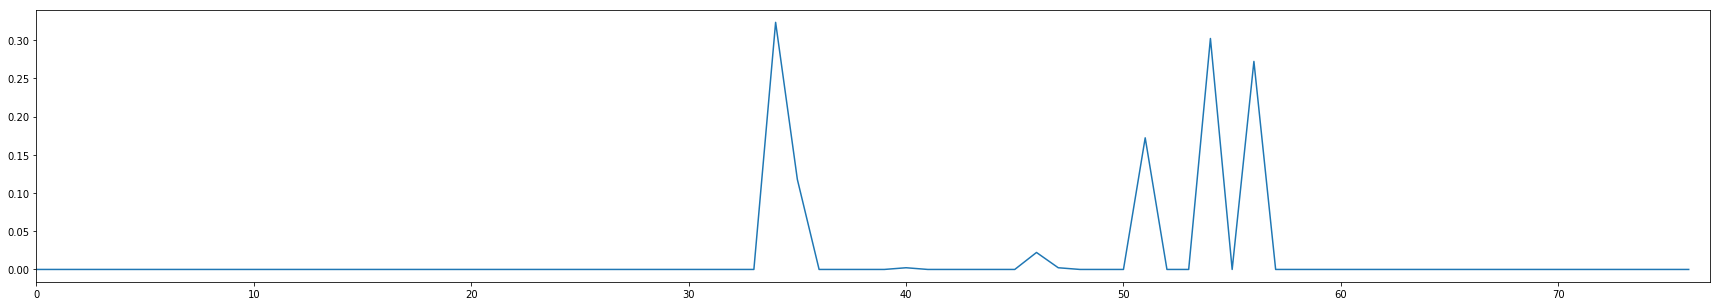

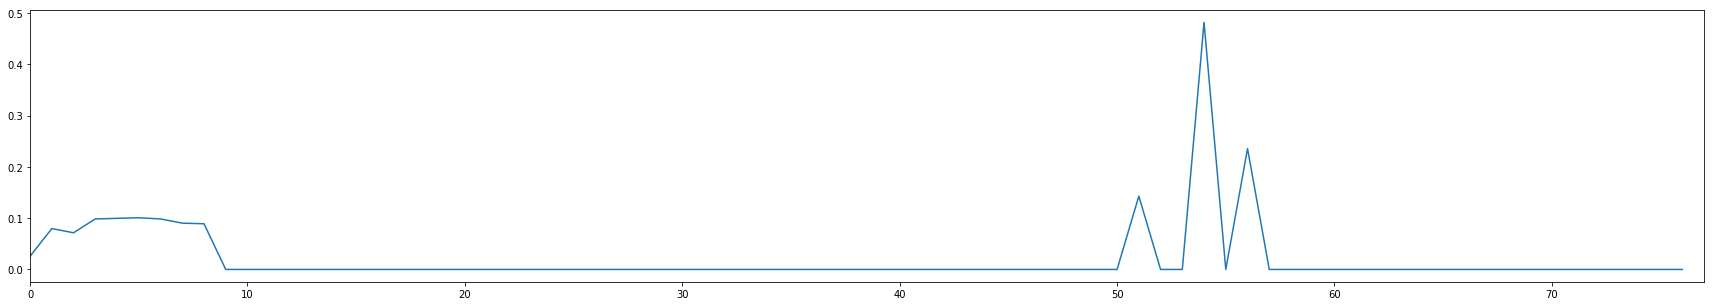

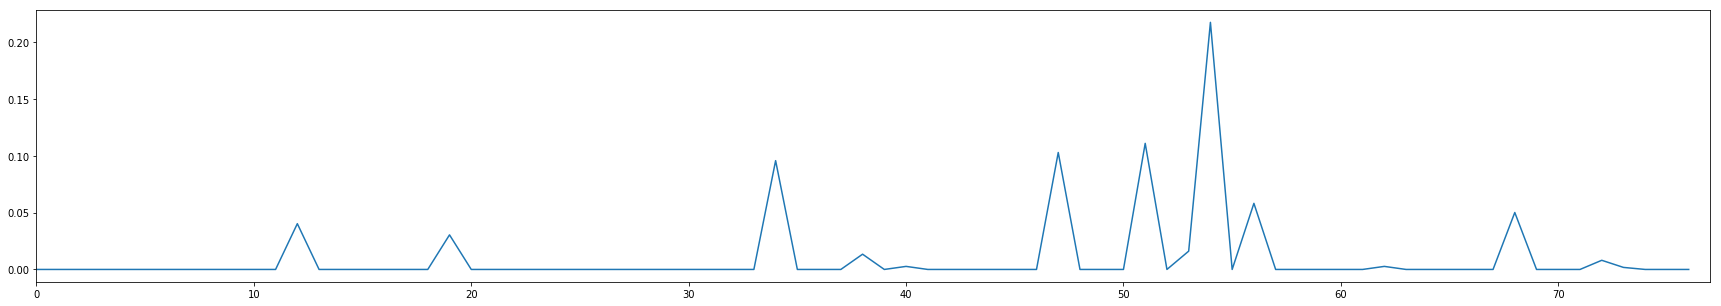

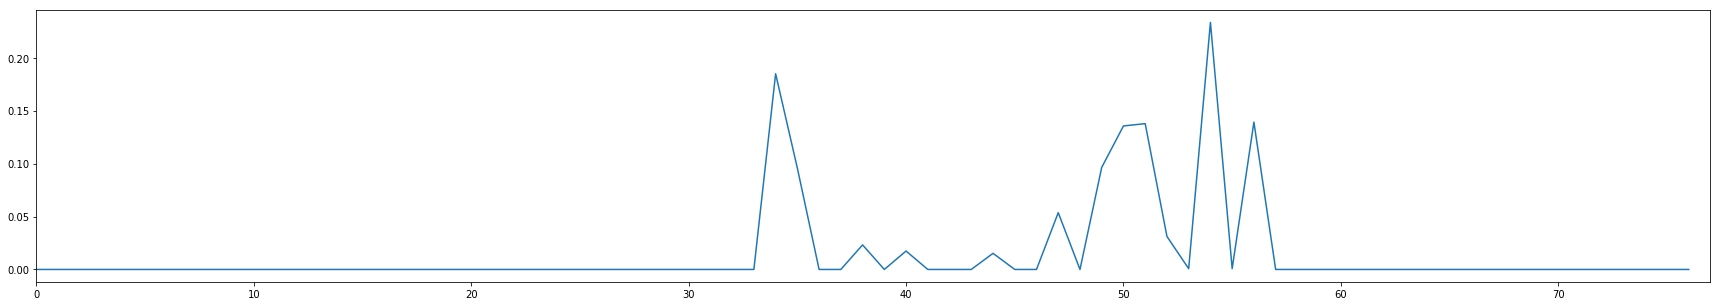

In [14]:
count = 0
for rw in features.values:
    plt.figure(figsize=(30,5))
    plt.xlim(0,len(rw[:-1]))
    plt.plot(rw[:-1])

    #plt.savefig(train_root+ "pics/" + "en:" + str(en) + "-" + "loc:" +str(count) +".png")
    plt.show()
    count = count + 1

In [51]:
features.loc[:,0:76]

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.133142,0.119732,0.113027,0.113027,0.086207,0.062261,0.003831,0.035441,0.064176,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041394,...,0.030501,0.000000,0.000000,0.00,0.050109,0.054466,0.054466,0.008715,0.041394,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.141985,0.145038,0.163359,0.174046,0.163359,0.138931,0.114504,0.138931,0.151145,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.019563,0.00,0.000000,0.009206,0.000000,0.040276,0.000000,0.039125
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
#features.to_csv(train_root + "features", header=False, index=False) 

In [52]:
data_covariance = features.loc[:,0:76].cov()

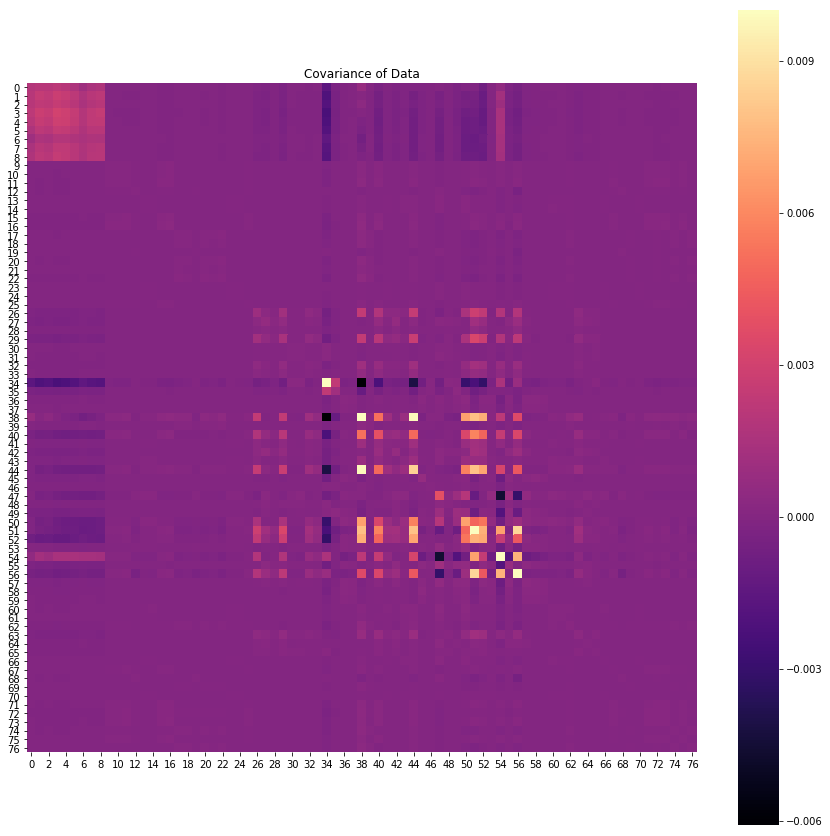

In [53]:
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(data_covariance, vmax=0.01 , cmap="magma",square=True)
plt.title("Covariance of Data")
plt.show()

In [54]:
data_correlation = features.loc[:,0:76].corr()

In [68]:
data_correlation = np.abs(data_correlation)

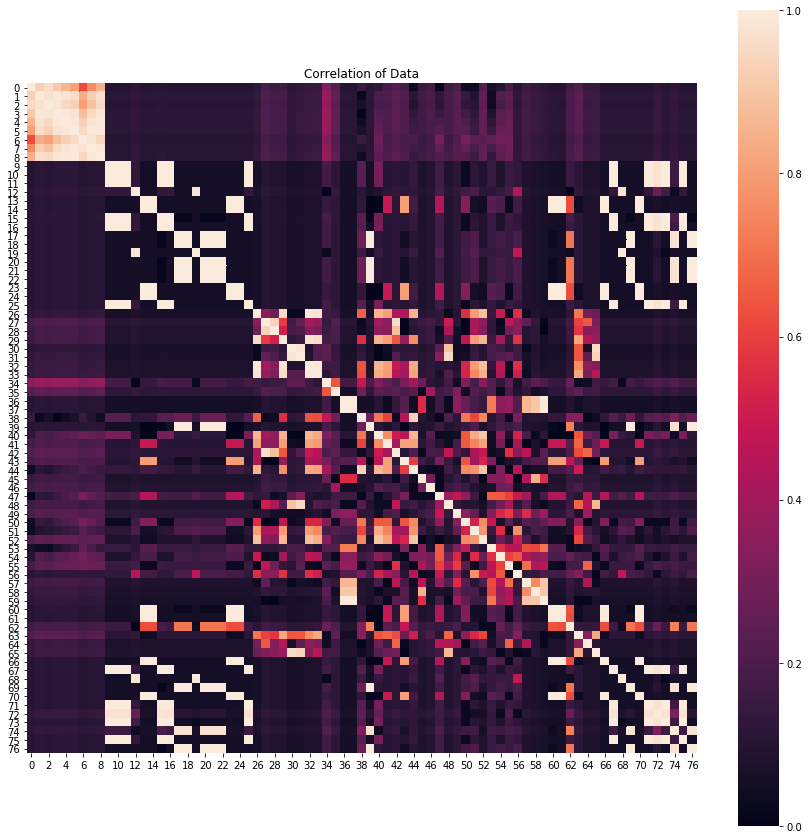

In [70]:
plt.figure(figsize=(15, 15))
sns.heatmap(data_correlation, vmin=0 , square=True)
plt.title("Correlation of Data")
plt.show()

In [59]:
X=features.loc[:,0:76]
y=features.loc[:,77:77]

In [61]:
len(X)

20

plt.figure(figsize=(10,10))
plt.imshow(dist, cmap='jet', interpolation='nearest', origin='upper', extent=[0,len(dist[0]),0,len(motif_representatives.values)], aspect='auto')

motif_representatives.index = motif_representatives[0]

ids = motif_representatives.index
ids = ids.astype(int)

feat = []
mot_sum = 0
for location in range(0,len(place)):
    for row in range(0,len(disc_mot)):
        count = 0
        for element in range(0,len(place[location])):
            if place[location][element] == 1:
                if disc_mot[row][element] == 1:
                    count = count+1
        feat.append([location,row,count])

feature_list = []
for f in feat:

    feature_list.append([f[0],f[1],float(f[2])])
#feature_list.append(ft)

feature_list = pd.DataFrame(feature_list)

env_wise_sum = []
for locs in set(feature_list[0]):
    #print locs
    #print feature_list[feature_list[0]==locs][2].sum()
    env_wise_sum.append([locs,feature_list[feature_list[0]==locs][2].sum()])

env_wise_sum

test = []
for sums in env_wise_sum:
    print sums
    test.append(list(feature_list[feature_list[0]==sums[0]][2]/sums[1]))

feature_list['3'] = np.array(test).reshape(-1)

feature_list.drop(feature_list.columns[2], axis=1, inplace=True)

feature_list

feature_list.values[:,0]

loc_wise_ft = []
for e in set(feature_list.values[:,0]):
    lwf = []
    for row in feature_list.values:
        if row[0] == e:
            print row[2]
            lwf.extend([float(row[2])])
    loc_wise_ft.append(lwf)

len(loc_wise_ft[0])

pd.DataFrame(loc_wise_ft)

for rw in loc_wise_ft:
    plt.figure(figsize=(30,5))
    plt.xlim(0,len(rw))
    plt.plot(rw)

In [37]:
#feature_list.to_csv(test_root + "features", header=False, index=False)